In [1]:
import numpy as  np
import pandas as pd
import matplotlib.pyplot as plt

#### **Load the data**

In [2]:
df = pd.read_csv('all_kindle_review.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,asin,helpful,rating,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,11539,B0033UV8HI,"[8, 10]",3,"Jace Rankin may be short, but he's nothing to ...","09 2, 2010",A3HHXRELK8BHQG,Ridley,Entertaining But Average,1283385600
1,1,5957,B002HJV4DE,"[1, 1]",5,Great short read. I didn't want to put it dow...,"10 8, 2013",A2RGNZ0TRF578I,Holly Butler,Terrific menage scenes!,1381190400
2,2,9146,B002ZG96I4,"[0, 0]",3,I'll start by saying this is the first of four...,"04 11, 2014",A3S0H2HV6U1I7F,Merissa,Snapdragon Alley,1397174400
3,3,7038,B002QHWOEU,"[1, 3]",3,Aggie is Angela Lansbury who carries pocketboo...,"07 5, 2014",AC4OQW3GZ919J,Cleargrace,very light murder cozy,1404518400
4,4,1776,B001A06VJ8,"[0, 1]",4,I did not expect this type of book to be in li...,"12 31, 2012",A3C9V987IQHOQD,Rjostler,Book,1356912000


#### **Import required libraries for text data processing**

In [3]:
import re
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
df = df[['rating','reviewText']] ## We need only these 2 columns for the analysis

In [5]:
## Converting the rating to a sentiment(0=Negative,1=Positive)
def conv_rating(row):
    if row<3:
        return 0
    else:
        return 1
df['Sentiment']=df['rating'].apply(conv_rating)
df['reviewText'] = df['reviewText'].str.lower() ## Lowering the texts

<ipython-input-5-8b83ea8b3473>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment']=df['rating'].apply(conv_rating)
<ipython-input-5-8b83ea8b3473>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reviewText'] = df['reviewText'].str.lower() ## Lowering the texts


In [6]:
## Text data processing(Removing special charecters, Stopwards, URL, HTML tags, additional spaces and Lemmatization)
lemmatizer = WordNetLemmatizer()
def text_processing(row):
  text=re.sub('[^a-z A-Z 0-9-]+','',row) ## Removing Special charecters
  text=" ".join([y for y in text.split() if y not in stopwords.words('english')]) ## Removing stopwards
  text=re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , str(text)) ## Removing URLs
  text=BeautifulSoup(text, 'lxml').get_text() ## Removing html tags
  text=" ".join(text.split()) ## Removing additional spaces
  return " ".join([lemmatizer.lemmatize(word)for word in text.split()]) ## Lemmatization

In [7]:
df['reviewText']=df['reviewText'].apply(text_processing)
df['reviewText']

,reviewText
0,jace rankin may short he nothing mess man haul...
1,great short read didnt want put read one sitti...
2,ill start saying first four book wasnt expecti...
3,aggie angela lansbury carry pocketbook instead...
4,expect type book library pleased find price right
...,...
11995,valentine cupid vampire- jena ian another vamp...
11996,read seven book series apocalypticadventure on...
11997,book really wasnt cuppa situation man capturin...
11998,tried use charge kindle didnt even register ch...


#### **Data split, model building and model evalution**

In [8]:
from sklearn.model_selection import train_test_split
bow=CountVectorizer()
x_train,x_test,y_train,y_test=train_test_split(df['reviewText'],df['Sentiment'],test_size=0.2,random_state=42)

*Bag of wards*

In [9]:
x_train_bow = bow.fit_transform(x_train).toarray()
x_test_bow = bow.transform(x_test).toarray()

*TF-IDF*


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
x_train_tfidf = tfidf.fit_transform(x_train).toarray()
x_test_tfidf = tfidf.transform(x_test).toarray()

*Word2Vec*

In [11]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
sentence = []
for i in df['reviewText']:
  sentence.append(word_tokenize(i))
w2v = Word2Vec(sentences=sentence,vector_size=100,window=5,min_count=1,sg=0) ##Train Word2Vec model

In [13]:
data=[]
labels=[]
for corpus,label in zip(sentence,df['Sentiment']):
  data.append(np.mean(w2v.wv[corpus],axis=0))
  labels.append(label)
data=np.array(data)
labels=np.array(labels)
x_train_w2v,x_test_w2v,y_train_w2v,y_test_w2v=train_test_split(data,labels,test_size=0.2,random_state=42)

Model building

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [15]:
rf = RandomForestClassifier(n_estimators=100,criterion='gini')
ft = rf.fit(x_train_bow,y_train)
print('Classification report for BOW')
print(classification_report(y_test,ft.predict(x_test_bow)))

Classification report for BOW
              precision    recall  f1-score   support

           0       0.88      0.48      0.62       803
           1       0.79      0.97      0.87      1597

    accuracy                           0.80      2400
   macro avg       0.83      0.72      0.74      2400
weighted avg       0.82      0.80      0.78      2400



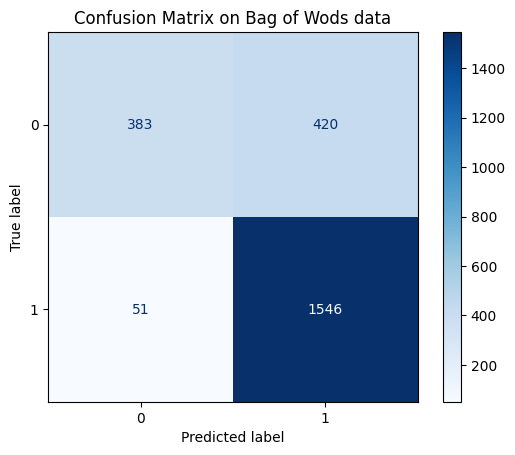

In [16]:
cm=confusion_matrix(y_test,ft.predict(x_test_bow))
disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Bag of Wods data")
plt.show()

In [17]:
rf1 = RandomForestClassifier(n_estimators=100,criterion='gini')
ft1 = rf1.fit(x_train_tfidf,y_train)
print('Classification report for TF-IDF')
print(classification_report(y_test,ft1.predict(x_test_tfidf)))

Classification report for TF-IDF
              precision    recall  f1-score   support

           0       0.87      0.42      0.57       803
           1       0.77      0.97      0.86      1597

    accuracy                           0.79      2400
   macro avg       0.82      0.70      0.71      2400
weighted avg       0.80      0.79      0.76      2400



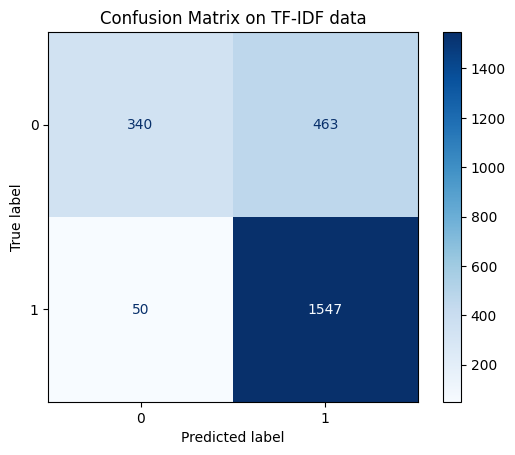

In [18]:
cm1=confusion_matrix(y_test,ft1.predict(x_test_tfidf))
disp=ConfusionMatrixDisplay(confusion_matrix=cm1)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on TF-IDF data")
plt.show()

In [19]:
rf2 = RandomForestClassifier(n_estimators=100,criterion='gini')
ft2 = rf2.fit(x_train_w2v,y_train_w2v)
print('Classification report for Word2Vec')
print(classification_report(y_test_w2v,ft2.predict(x_test_w2v)))

Classification report for Word2Vec
              precision    recall  f1-score   support

           0       0.69      0.55      0.61       803
           1       0.80      0.88      0.83      1597

    accuracy                           0.77      2400
   macro avg       0.74      0.71      0.72      2400
weighted avg       0.76      0.77      0.76      2400



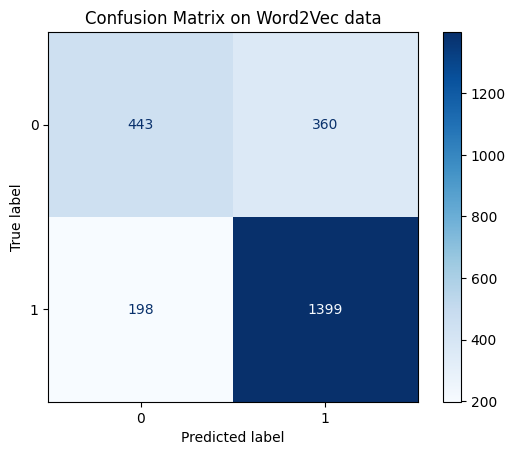

In [21]:
cm2=confusion_matrix(y_test_w2v,ft2.predict(x_test_w2v))
disp=ConfusionMatrixDisplay(confusion_matrix=cm2)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Word2Vec data")
plt.show()